In [1]:
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import numpy as np
import pandas as pd
from shutil import copyfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from PIL import Image, ImageDraw
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader

## Формируем датасеты

In [2]:
def show_box(image,boxes,labels,colors = {0:'red',1:'green',2:'blue'}):
    if type(image) == torch.Tensor:
        img = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().detach().numpy())
    else:
        img = image.copy()
    draw = ImageDraw.Draw(img)
    for box,label in zip(boxes,labels):
        color = colors[label]
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=2)
        draw.text((box[0]+3, box[1]+3), str(label), fill=None, font=None, embedded_color=False, font_size=None)
    display(img)

In [3]:
#получаем таргеты и соответствующие им имена файлов картинок
annotations = glob(r'BCCD_Dataset-master\BCCD\Annotations\*.xml')

df = []
cnt = 0
for file in annotations:
    #filename = file.split('/')[-1].split('.')[0] + '.jpg'
    #filename = str(cnt) + '.jpg'
    filename = file.split('\\')[-1]
    filename =filename.split('.')[0] + '.jpg'
    row = []
    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
        blood_cells = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [filename, blood_cells, xmin, xmax, ymin, ymax]
        df.append(row)
        cnt += 1
data = pd.DataFrame(df, columns=['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('test.csv', index=False)

In [4]:
data['boxes'] = data[['xmin', 'ymin', 'xmax', 'ymax']].agg(np.array,axis= 1) 
data['boxes'].head()

0    [260, 177, 491, 376]
1     [78, 336, 184, 435]
2     [63, 237, 169, 336]
3    [214, 362, 320, 461]
4    [414, 352, 506, 445]
Name: boxes, dtype: object

In [5]:
#удаляем боксы с нулевой площадью, оказалось два таких
data = data[~((data['xmin']==data['xmax']) & (data['ymin']==data['ymax']))].reset_index(drop=True)

In [7]:
#le = LabelEncoder()
#le.fit(data['cell_type'])

data['labels'] = data['cell_type'].map({'Platelets':1,'RBC':2,'WBC':3})
colors = {1:'red',2:'green',3:'blue'}

In [8]:
data[['cell_type','labels']].value_counts()

cell_type  labels
RBC        2         4153
WBC        3          372
Platelets  1          361
dtype: int64

In [10]:
dummies = pd.get_dummies( data['cell_type'])

In [11]:
data[dummies.columns]  = dummies

In [12]:
# группируем по файлу подготавливаем поля boxes и labels
data = data.groupby('filename').agg(
    boxes = ('boxes',np.vstack),
    labels = ('labels',lambda x: list(x)),
    Platelets = ('Platelets','sum'),
    RBC = ('RBC','sum'),
    WBC = ('WBC','sum')
    ).reset_index()
data['labels'] = data['labels'].apply(np.array)
data[['Platelets','RBC','WBC']] = np.sign(data[['Platelets','RBC','WBC']])
data

,filename,boxes,labels,Platelets,RBC,WBC
0,BloodImage_00000.jpg,"[[260, 177, 491, 376], [78, 336, 184, 435], [6...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0,1,1
1,BloodImage_00001.jpg,"[[68, 315, 286, 480], [346, 361, 446, 454], [5...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0,1,1
2,BloodImage_00002.jpg,"[[385, 98, 523, 198], [384, 164, 499, 260], [1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]",0,1,1
3,BloodImage_00003.jpg,"[[127, 40, 344, 226], [317, 93, 424, 195], [37...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,1,1
4,BloodImage_00004.jpg,"[[109, 134, 324, 321], [432, 242, 528, 325], [...","[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]",1,1,1
...,...,...,...,...,...,...
359,BloodImage_00405.jpg,"[[53, 306, 162, 412], [1, 203, 68, 322], [162,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]",0,1,1
360,BloodImage_00407.jpg,"[[30, 168, 140, 264], [12, 35, 109, 133], [25,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,1,1
361,BloodImage_00408.jpg,"[[64, 279, 139, 415], [118, 120, 232, 219], [1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,1,1
362,BloodImage_00409.jpg,"[[518, 168, 611, 268], [426, 87, 551, 198], [5...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...",1,1,1


In [13]:
#делим данные на трейн и тест так, чтобы более менее равномерно распределились картинки с 
#одним или несколькими типами клеток
train, test = train_test_split(data[['filename','boxes','labels']], test_size=0.20, 
                               random_state=42, 
                               shuffle=True, 
                               stratify=data[['Platelets','RBC','WBC']].sum(axis=1))
print(f'train len: {train.shape[0]}, test len: {test.shape[0]}')

train len: 291, test len: 73


In [15]:
#Посмотрим на распределение типов клеток в тренировочном и тестовом наборах, всё ли пропорционально
t = train['labels'].apply(lambda x: (x[x==1].shape[0],x[x==2].shape[0],x[x==3].shape[0]))
t.apply(lambda x: np.array(x))
print('train',np.vstack(t.apply(lambda x: np.array(x))).sum(axis=0))
t = test['labels'].apply(lambda x: (x[x==1].shape[0],x[x==2].shape[0],x[x==3].shape[0]))
t.apply(lambda x: np.array(x))
print('test',np.vstack(t.apply(lambda x: np.array(x))).sum(axis=0))

train [ 289 3331  300]
test [ 72 822  72]


In [16]:
train.loc[0]

filename                                 BloodImage_00000.jpg
boxes       [[260, 177, 491, 376], [78, 336, 184, 435], [6...
labels      [3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
Name: 0, dtype: object

In [17]:
from engine import train_one_epoch, evaluate
import utils

In [18]:
class BCCD_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs, self.targets = get_dataset_raw(df,root)
        
    def __getitem__(self, idx):
        
        img = self.imgs[idx]
        
        target = {}
        target["boxes"] = self.targets[idx]['boxes']
        target["labels"] = self.targets[idx]['labels']
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
    
#функция формирует набор данных для создания датасета (так как данных немного, можно не считывать по одной каринке)
def get_dataset_raw(df,root):
    X = []
    y = []
    for v in df.iterrows():
        filename = v[1]['filename']
        boxes  =  v[1]['boxes']
        labels =  v[1]['labels']
        #print(f'{filename} {boxes} {labels}')
        X.append(get_img_tesor(filename,root))
        y.append(
                {'boxes':torch.Tensor(boxes).float(),
                  'labels':torch.Tensor(labels).long()}
                )
    return X,y

#функция для превращения тензора в картинку
def get_img_tesor(path,root):
    image = Image.open(root+ "\\" + path)
    convert_tensor = transforms.ToTensor()
    img_tensor = convert_tensor(image)
    return img_tensor

In [19]:
#формируем датасеты
root = r"C:\Users\RK\BCCD_Dataset-master\BCCD\JPEGImages" 
train_dataset = BCCD_Dataset(train,root)
test_dataset = BCCD_Dataset(test,root)

In [20]:
train_dl = DataLoader(train_dataset,batch_size=1,shuffle=True,collate_fn=utils.collate_fn)
test_dl = DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn=utils.collate_fn)

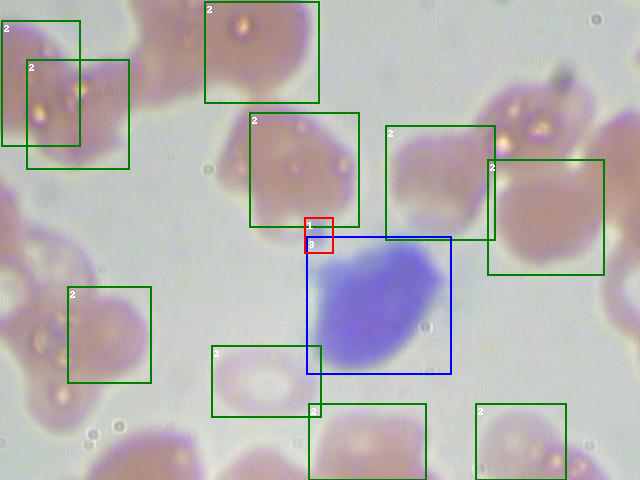

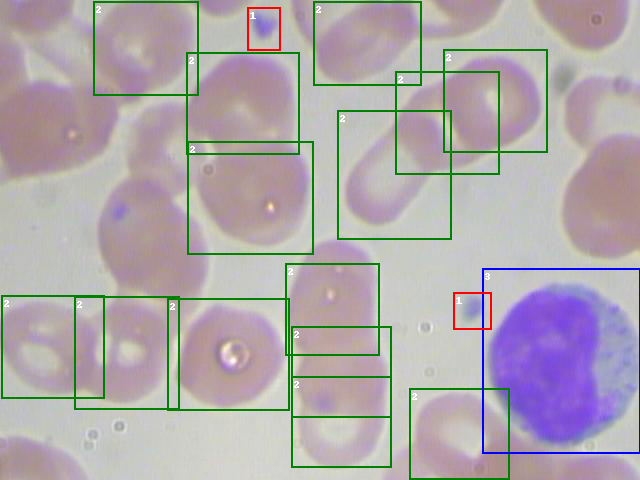

In [23]:
#Посмотрим сами картинки в наших датасетах
idx_image = 1
show_box(train_dataset[idx_image][0],
         train_dataset[idx_image][1]['boxes'].numpy(),
         train_dataset[idx_image][1]['labels'].numpy(),
         colors = colors)

idx_image = 10
show_box(test_dataset[idx_image][0],
         test_dataset[idx_image][1]['boxes'].numpy(),
         test_dataset[idx_image][1]['labels'].numpy(),
         colors = colors)

In [ ]:
#Z,c = get_dataset_raw(test,root)

In [ ]:
#c[0]['boxes']

In [ ]:
#test_dataset[0]

In [ ]:
#for X, y in test_dl:
#    print(X)
#    print(y)
#    break

### Создаём и обучаем модель

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4

# get the model using our helper function
model = ssd300_vgg16(num_classes=num_classes)
#model

In [25]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                            momentum=0.9)
optimizer =  torch.optim.Adam(params=params, lr=0.001)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [26]:
num_epochs = 65

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=len(train_dl.dataset.imgs))
    # update the learning rate
    #lr_scheduler.step()

Epoch: [0]  [  0/291]  eta: 0:02:40  lr: 0.000004  loss: 27.3226 (27.3226)  bbox_regression: 6.5773 (6.5773)  classification: 20.7453 (20.7453)  time: 0.5510  data: 0.0010  max mem: 472
Epoch: [0]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 4.3809 (5.6477)  bbox_regression: 1.8342 (2.0891)  classification: 2.4586 (3.5586)  time: 0.0328  data: 0.0001  max mem: 590
Epoch: [0] Total time: 0:00:10 (0.0346 s / it)
Epoch: [1]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 4.5772 (4.5772)  bbox_regression: 1.7141 (1.7141)  classification: 2.8630 (2.8630)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [1]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 3.8343 (4.1385)  bbox_regression: 1.3442 (1.6561)  classification: 2.3251 (2.4824)  time: 0.0347  data: 0.0002  max mem: 590
Epoch: [1] Total time: 0:00:09 (0.0338 s / it)
Epoch: [2]  [  0/291]  eta: 0:00:10  lr: 0.001000  loss: 3.5528 (3.5528)  bbox_regression: 1.3435 (1.3435)  classification: 2.2093 (2.2093)  time: 0.0350  data: 0.0000  max m

Epoch: [20]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 1.9101 (2.0246)  bbox_regression: 0.5576 (0.5837)  classification: 1.3370 (1.4409)  time: 0.0322  data: 0.0001  max mem: 590
Epoch: [20] Total time: 0:00:09 (0.0320 s / it)
Epoch: [21]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 2.0020 (2.0020)  bbox_regression: 0.5386 (0.5386)  classification: 1.4634 (1.4634)  time: 0.0320  data: 0.0010  max mem: 590
Epoch: [21]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 1.4088 (1.6556)  bbox_regression: 0.3979 (0.4836)  classification: 1.0252 (1.1720)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [21] Total time: 0:00:09 (0.0320 s / it)
Epoch: [22]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 1.1954 (1.1954)  bbox_regression: 0.3258 (0.3258)  classification: 0.8696 (0.8696)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [22]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 1.4600 (1.5044)  bbox_regression: 0.4665 (0.4636)  classification: 0.9830 (1.0408)  time: 0.0321  data: 0.0000  ma

Epoch: [40]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 2.8221 (1.2127)  bbox_regression: 0.8339 (0.4306)  classification: 2.0254 (0.7821)  time: 0.0328  data: 0.0002  max mem: 590
Epoch: [40] Total time: 0:00:09 (0.0327 s / it)
Epoch: [41]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 3.0025 (3.0025)  bbox_regression: 0.9828 (0.9828)  classification: 2.0197 (2.0197)  time: 0.0330  data: 0.0010  max mem: 590
Epoch: [41]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 1.8099 (2.4693)  bbox_regression: 0.5604 (0.7468)  classification: 1.2494 (1.7226)  time: 0.0324  data: 0.0001  max mem: 590
Epoch: [41] Total time: 0:00:09 (0.0326 s / it)
Epoch: [42]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 1.5185 (1.5185)  bbox_regression: 0.5192 (0.5192)  classification: 0.9993 (0.9993)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [42]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 0.7321 (1.1717)  bbox_regression: 0.3440 (0.4452)  classification: 0.3937 (0.7265)  time: 0.0321  data: 0.0001  ma

Epoch: [60]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 0.2466 (0.3049)  bbox_regression: 0.1466 (0.1876)  classification: 0.1179 (0.1173)  time: 0.0328  data: 0.0001  max mem: 590
Epoch: [60] Total time: 0:00:09 (0.0321 s / it)
Epoch: [61]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 0.0923 (0.0923)  bbox_regression: 0.0732 (0.0732)  classification: 0.0191 (0.0191)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [61]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 0.1678 (0.1973)  bbox_regression: 0.1252 (0.1350)  classification: 0.0358 (0.0623)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [61] Total time: 0:00:09 (0.0321 s / it)
Epoch: [62]  [  0/291]  eta: 0:00:09  lr: 0.001000  loss: 0.1059 (0.1059)  bbox_regression: 0.0842 (0.0842)  classification: 0.0216 (0.0216)  time: 0.0320  data: 0.0000  max mem: 590
Epoch: [62]  [290/291]  eta: 0:00:00  lr: 0.001000  loss: 0.1137 (0.1592)  bbox_regression: 0.1006 (0.1155)  classification: 0.0232 (0.0437)  time: 0.0320  data: 0.0000  ma

In [27]:
#torch.save(model.state_dict(), 'deep_learning_10.pt')

In [39]:
def get_result(prediction):
    display(prediction[0]['scores'])
    display(prediction[0]['labels'])
    return 

def evaluete(idx_image,p=0.2,show_image=True,ds='test'):
    
    if ds == 'test':
        dset = test_dataset
        data = test
    elif ds == 'train':
        dset = train_dataset
        data = train
    else:
        raise RuntimeError(f'no dataset name {ds}')
        
    img = test_dataset[idx_image][0]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    
    if not show_image:
        get_result(prediction)
        return
    
    show_boxes = prediction[0]['boxes'][prediction[0]['scores'] > p]
    show_labels = prediction[0]['labels'][prediction[0]['scores'] > p]
    
    print('prediction')
    show_box(img,show_boxes.cpu().numpy(),show_labels.cpu().numpy(),colors = colors)
    print('real')
    show_box(img,data.iloc[idx_image]['boxes'],data.iloc[idx_image]['labels'],colors = colors)
    return prediction

prediction


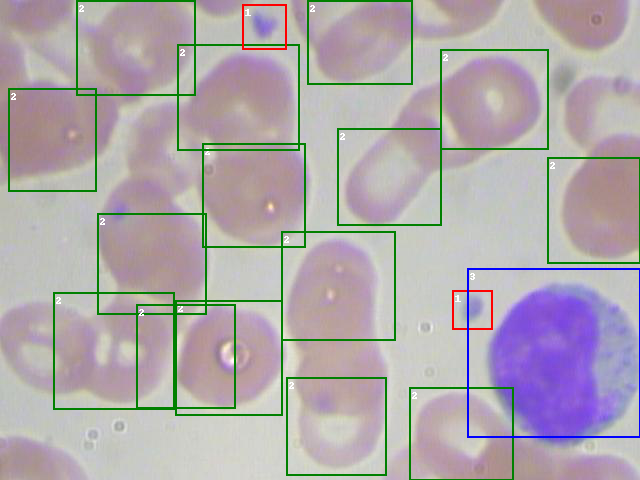

real


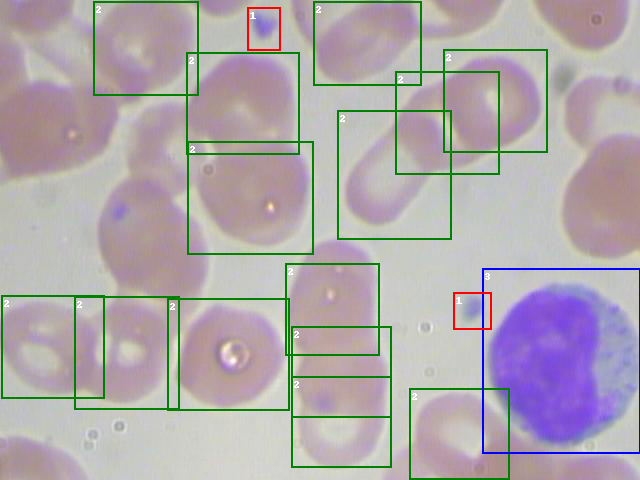

In [40]:
idx_image = 10
_ = evaluete(idx_image,ds='test')

prediction


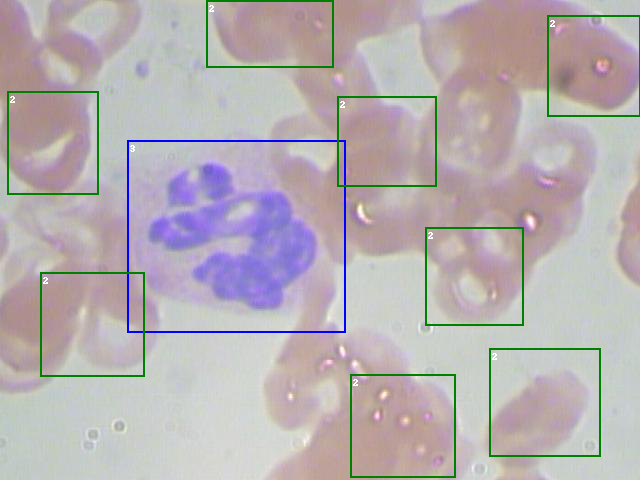

real


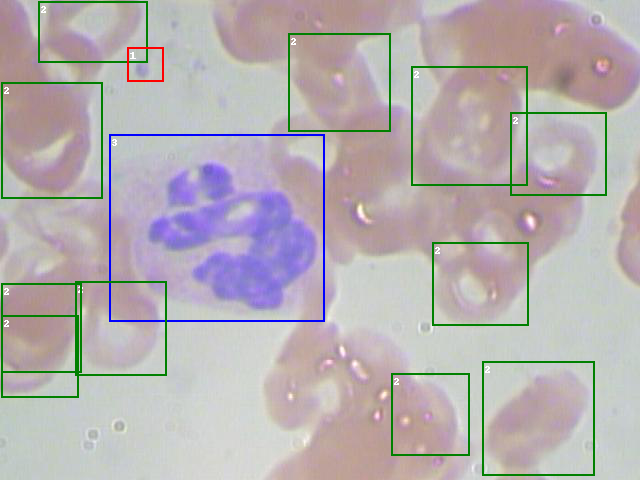

In [41]:
idx_image = 21
_ = evaluete(idx_image,ds='test')

prediction


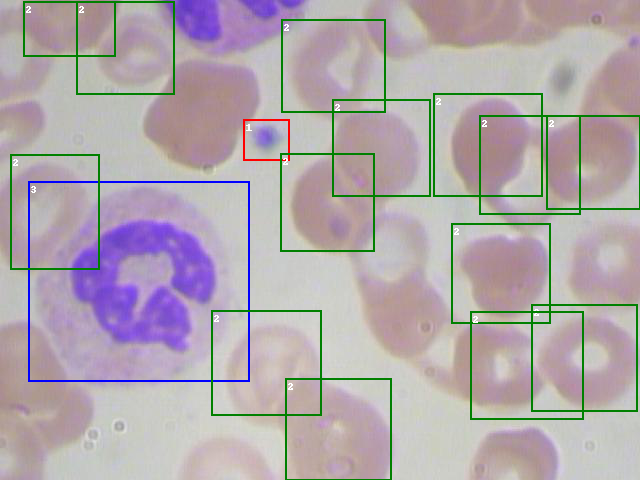

real


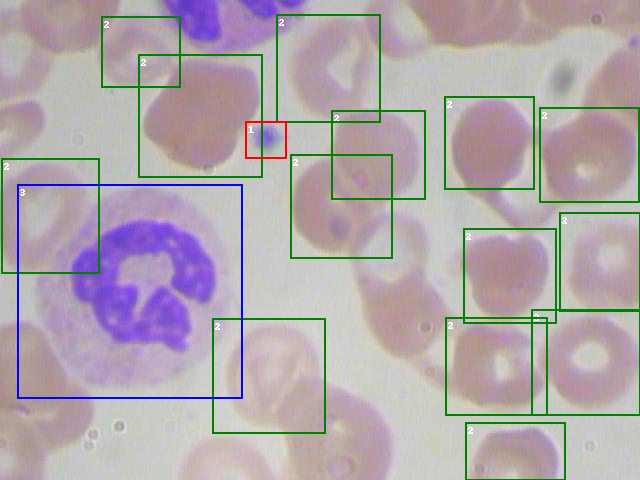

In [42]:
idx_image = 71
_ = evaluete(idx_image,ds='test')

Итого модель отрабатывает весьма неплохо, особенно хорошо если немного ограничить по score